<a href="https://colab.research.google.com/github/KimGriezmann/DeepLearning_BeTheLegend/blob/master/make_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
def data_crawling(year, num_top_batter=9):
  # Parameter
  # 원하는 연도 입력
  year = year
  # 데이터를 수집할 타자 중 타석 수 상위 명수
  num_top_batter = 9

  # Team List
  # 원하는 연도에 등록된 팀을 미리 넣어두어야함 (추가 가능)
  Team_2016 = ['NC','kt','LG','두산','히어로즈','KIA','롯데','삼성','SK','한화']
  Team_2017 = ['NC','kt','LG','두산','히어로즈','KIA','롯데','삼성','SK','한화']
  Team_2018 = ['NC','kt','LG','두산','히어로즈','KIA','롯데','삼성','SK','한화']
  Team_2019 = ['NC','kt','LG','두산','키움','KIA','롯데','삼성','SK','한화']
  Team_2020 = ['NC','kt','LG','두산','키움','KIA','롯데','삼성','SK','한화']
  Team_2021 = ['kt','삼성','LG','SSG','NC','키움','두산','롯데','KIA','한화']

  # Team Dictionary
  # Team List를 딕셔너리에 넣음 (추가 가능)
  TeamDic = {'2016':Team_2016, '2017':Team_2017, '2018':Team_2018, '2019':Team_2019, '2020':Team_2020, '2021':Team_2021}

  ###############
  # BeautifulSoup

  import numpy as np
  import pandas as pd
  import requests
  from bs4 import BeautifulSoup
  from tqdm import tqdm

  # 데이터를 모을 dataframe 생성
  data = pd.DataFrame(columns=['name','날짜', '상대', '결과', '타순', 'P', '선발', '타수', '득점', '안타', '2타', '3타', '홈런', '루타', '타점', '도루', '도실',
                              '볼넷', '사구', '고4', '삼진', '병살', '희타', '희비', 'avg', '출루', '장타', 'OPS', '투구', 'avLI', 'RE24', 'WPA'])

  batter_data = pd.DataFrame(columns=['Team','name'])

  for Team in tqdm(TeamDic[str(year)]): # 선택한 연도의 팀을 하나씩 가져옴
    
    # 스탯티즈 시즌기록실 페이지에서 연도, 팀 선택하고, 타석순으로 정렬
    wp = requests.get("http://www.statiz.co.kr/stat.php?opt=0&sopt=0&re=0&ys=" + str(year) + "&ye=" + str(year) + "&se=0&te=" + Team + "&tm=&ty=0&qu=auto&po=0&as=&ae=&hi=&un=&pl=&da=1&o1=TPA&o2=TPA&de=1&lr=0&tr=&cv=&ml=1&sn=30&si=&cn=")
    soup = BeautifulSoup(wp.text, "html.parser")
    
    # 현재 팀의 타석 수 상위 num_top_batter 명
    tmp_batter_list = np.empty(num_top_batter,dtype=object)
    tmp_team = np.array([Team]*num_top_batter) # 타석 수 상위 타자 팀명 저장
    tmp_batter_list_href = np.empty(num_top_batter,dtype=object)
    tmp_batter_ps=0
    for batter in soup.find_all('tr')[2:11]:
      tmp_batter_list[tmp_batter_ps] = batter.find_all('td')[1].text # 타석 수 상위 타자 이름 저장
      tmp_batter_list_href[tmp_batter_ps] = batter.find_all('a')[0].attrs['href'] # 타석 수 상위 타자 주소 저장
      tmp_batter_ps+=1

    batter_data = pd.concat([batter_data, pd.DataFrame({'Team':tmp_team, 'name':tmp_batter_list})])

    # 타석 수 상위 타자들 중 한명씩 데이터를 모으는 과정
    for top_batter in range(num_top_batter):
      wp=requests.get("http://www.statiz.co.kr/"+tmp_batter_list_href[top_batter]) # 타자 주소로 접근
      soup=BeautifulSoup(wp.text, "html.parser")

      # 날짜별 데이터로 접근
      href_byDate = soup.select('body > div > div.content-wrapper > div > section.content > div > div:nth-of-type(1) > div > div.col-xs-12.col-sm-8.col-md-8.col-lg-12 > div > div.table-responsive.no-padding.box > table')[0].find_all('a')[3].attrs['href']
      wp=requests.get("http://www.statiz.co.kr/"+href_byDate)
      soup=BeautifulSoup(wp.text,"html.parser")

      # year : 원하는 연도로 접근
      href_byDate_year=soup.select('body > div.wrapper > div.content-wrapper > div > section.content > div > div:nth-of-type(2) > div > div:nth-of-type(2) > div')[0].find('a', text=str(year)).attrs['href']
      wp=requests.get("http://www.statiz.co.kr/"+href_byDate_year)
      soup=BeautifulSoup(wp.text,"html.parser")

      ## 데이터가 있는 페이지로 이동 완료
      ## 이제 실질적인 데이터를 모을 차례
      rawdata=soup.select('body > div > div.content-wrapper > div > section.content > div > div:nth-of-type(2) > div > div:nth-of-type(3) > div > div > table')[0]
      # rawdata : 전체 테이블

      # th를 제외한 순수한 경기 데이터 / th는 컬럼명 행이다.
      rawdata_not_th = rawdata.find_all('tr',{'class':['oddrow_stz0','evenrow_stz0']})

      # 행렬만들기
      rawdata_name = np.array([tmp_batter_list[top_batter]]*len(rawdata_not_th))
      rawdata_day = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_vs_team = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_result = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_bat_order = np.zeros(len(rawdata_not_th),dtype=np.int_)
      rawdata_position = np.zeros(len(rawdata_not_th), dtype=object)
      rawdata_start_memeber = np.zeros(len(rawdata_not_th), dtype=np.bool)
      rawdata_ab = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_score = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_hit = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_2_hit = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_3_hit = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_homerun = np.zeros(len(rawdata_not_th), dtype=np.int_)
      # 영어명으로 변경 필요
      rawdata_루타 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_타점 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_도루 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_도실 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_볼넷 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_사구 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_고4 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_삼진 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_병살 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_희타 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rewdata_희비 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_avg = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_출루 = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_장타 = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_ops = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_투구 = np.zeros(len(rawdata_not_th), dtype=np.int_)
      rawdata_avLI = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_RE24 = np.zeros(len(rawdata_not_th), dtype=np.float)
      rawdata_WPA = np.zeros(len(rawdata_not_th), dtype=np.float)

      for rawdata_not_th_tr_index in range(len(rawdata_not_th)):
        # 한 행 : rawdata_not_th_tr_index
        rawdata_not_th_td = [text for text in rawdata_not_th[rawdata_not_th_tr_index].stripped_strings]
        # 현재 행의 하나의 값 : rawdata_not_th_td[index]
        # 데이터 입력
        rawdata_day[rawdata_not_th_tr_index] = rawdata_not_th_td[1]
        rawdata_vs_team[rawdata_not_th_tr_index] = rawdata_not_th_td[2]
        rawdata_result[rawdata_not_th_tr_index] = rawdata_not_th_td[3]+" "+rawdata_not_th_td[4]
        rawdata_bat_order[rawdata_not_th_tr_index] = rawdata_not_th_td[5]
        rawdata_position[rawdata_not_th_tr_index] = rawdata_not_th_td[6]
        rawdata_start_memeber[rawdata_not_th_tr_index] = rawdata_not_th_td[7]
        rawdata_ab[rawdata_not_th_tr_index] = rawdata_not_th_td[8]
        rawdata_score[rawdata_not_th_tr_index] = rawdata_not_th_td[9]
        rawdata_hit[rawdata_not_th_tr_index] = rawdata_not_th_td[10]
        rawdata_2_hit[rawdata_not_th_tr_index] = rawdata_not_th_td[11]
        rawdata_3_hit[rawdata_not_th_tr_index] = rawdata_not_th_td[12]
        rawdata_homerun[rawdata_not_th_tr_index] = rawdata_not_th_td[13]
        rawdata_루타[rawdata_not_th_tr_index] = rawdata_not_th_td[14]
        rawdata_타점[rawdata_not_th_tr_index] = rawdata_not_th_td[15]
        rawdata_도루[rawdata_not_th_tr_index] = rawdata_not_th_td[16]
        rawdata_도실[rawdata_not_th_tr_index] = rawdata_not_th_td[17]
        rawdata_볼넷[rawdata_not_th_tr_index] = rawdata_not_th_td[18]
        rawdata_사구[rawdata_not_th_tr_index] = rawdata_not_th_td[19]
        rawdata_고4[rawdata_not_th_tr_index] = rawdata_not_th_td[20]
        rawdata_삼진[rawdata_not_th_tr_index] = rawdata_not_th_td[21]
        rawdata_병살[rawdata_not_th_tr_index] = rawdata_not_th_td[22]
        rawdata_희타[rawdata_not_th_tr_index] = rawdata_not_th_td[23]
        rewdata_희비[rawdata_not_th_tr_index] = rawdata_not_th_td[24]
        rawdata_avg[rawdata_not_th_tr_index] = rawdata_not_th_td[25]
        rawdata_출루[rawdata_not_th_tr_index] = rawdata_not_th_td[26]
        rawdata_장타[rawdata_not_th_tr_index] = rawdata_not_th_td[27]
        rawdata_ops[rawdata_not_th_tr_index] = rawdata_not_th_td[28]
        rawdata_투구[rawdata_not_th_tr_index] = rawdata_not_th_td[29]
        rawdata_avLI[rawdata_not_th_tr_index] = rawdata_not_th_td[30]
        rawdata_RE24[rawdata_not_th_tr_index] = rawdata_not_th_td[31]
        rawdata_WPA[rawdata_not_th_tr_index] = rawdata_not_th_td[32]

      tmp_data = pd.DataFrame()
      # tmp_data는 각 선수마다 데이터를 모은 후 data에 머지하기 전에 존재
      tmp_data['name'] = rawdata_name
      tmp_data['day'] = rawdata_day
      tmp_data['vs_team'] = rawdata_vs_team
      tmp_data['결과'] = rawdata_result
      tmp_data['타순'] = rawdata_bat_order
      tmp_data['P'] = rawdata_position
      tmp_data['선발'] = rawdata_start_memeber
      tmp_data['ab'] = rawdata_ab
      tmp_data['득점'] = rawdata_score
      tmp_data['hit'] = rawdata_hit
      tmp_data['2타'] = rawdata_2_hit
      tmp_data['3타'] = rawdata_3_hit
      tmp_data['홈런'] = rawdata_homerun
      tmp_data['루타'] = rawdata_루타
      tmp_data['타점'] = rawdata_타점
      tmp_data['도루'] = rawdata_도루
      tmp_data['도실'] = rawdata_도실
      tmp_data['볼넷'] = rawdata_볼넷
      tmp_data['사구'] = rawdata_사구
      tmp_data['고4'] = rawdata_고4
      tmp_data['삼진'] = rawdata_삼진
      tmp_data['병살'] = rawdata_병살
      tmp_data['희타'] = rawdata_희타
      tmp_data['희비'] = rewdata_희비
      tmp_data['avg'] = rawdata_avg
      tmp_data['출루'] = rawdata_출루
      tmp_data['장타'] = rawdata_장타
      tmp_data['OPS'] = rawdata_ops
      tmp_data['투구'] = rawdata_투구
      tmp_data['avLI'] = rawdata_avLI
      tmp_data['RE24'] = rawdata_RE24
      tmp_data['WPA'] = rawdata_WPA

      # 데이터 쌓기
      data = pd.concat([data,tmp_data])

  return data, batter_data


In [4]:
# data_2018, batter_data_2018 = data_crawling(2018,9)
# data_2019, batter_data_2019 = data_crawling(2019,9)
# data_2020, batter_data_2020 = data_crawling(2020,9)
data_2021, batter_data_2021 = data_crawling(2021,9)

100%|██████████| 10/10 [09:40<00:00, 58.05s/it]


In [ ]:
data_2018.to_csv("data_2018.csv", encoding='euc-kr', index=False)
data_2019.to_csv("data_2019.csv", encoding='euc-kr', index=False)
data_2020.to_csv("data_2020.csv", encoding='euc-kr', index=False)
data_2021.to_csv("data_2021.csv", encoding='euc-kr', index=False)

batter_data_2018.to_csv("batter_data_2018.csv", encoding='euc-kr', index=False)
batter_data_2019.to_csv("batter_data_2019.csv", encoding='euc-kr', index=False)
batter_data_2020.to_csv("batter_data_2020.csv", encoding='euc-kr', index=False)
batter_data_2021.to_csv("batter_data_2021.csv", encoding='euc-kr', index=False)

In [6]:
ex_data = data_2021.loc[:, ['name', 'day', 'vs_team', 'ab', 'hit']]

In [7]:
ex_data

,name,day,vs_team,ab,hit
0,강백호,04-04,한화,3.0,2.0
1,강백호,04-06,LG,4.0,0.0
2,강백호,04-07,LG,4.0,3.0
3,강백호,04-08,LG,4.0,2.0
4,강백호,04-09,@삼성,5.0,3.0
...,...,...,...,...,...
37,김민하,06-23,@삼성,3.0,1.0
38,김민하,06-24,@삼성,4.0,0.0
39,김민하,06-26,KT,1.0,0.0
40,김민하,07-09,@SSG,4.0,1.0


In [32]:
import numpy as np
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
def make_result(data):
  data['result'] = [0 if s == 0 else 1 for s in data['hit']] 

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['result'] = data['result']
  result_Dataframe

  return result_Dataframe

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


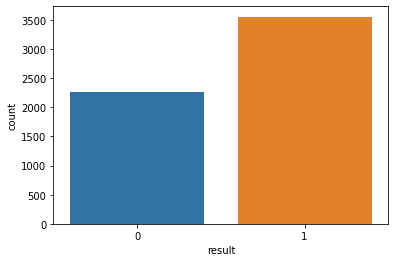

In [33]:
sns.countplot(ex_data['result'])
plt.show()

In [56]:
def make_vs(data):
  data['vs'] = [s[1:] if s[0] == '@' else s for s in data['vs_team']] 

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe

  return result_Dataframe

In [63]:
def make_home_away(data):
  data['home/away'] = ['away' if s[0] == '@' else 'home' for s in data['vs_team']]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe

  return result_Dataframe

In [102]:
def make_home_away_ab(data):
  data['home_ab'] = [ab if s == 'home' else 0 for s, ab in zip(data['home/away'], data['ab'])]
  data['home_hit'] = [hit if s == 'home' else 0 for s, hit in zip(data['home/away'], data['hit'])]
  data['away_ab'] = [ab if s == 'away' else 0 for s, ab in zip(data['home/away'], data['ab'])]
  data['away_hit'] = [hit if s == 'away' else 0 for s, hit in zip(data['home/away'], data['hit'])]

  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = data['name']
  result_Dataframe['day'] = data['day']
  result_Dataframe['vs_team'] = data['vs_team']
  result_Dataframe['vs'] = data['vs']
  result_Dataframe['ab'] = data['ab']
  result_Dataframe['hit'] = data['hit']
  result_Dataframe['home/away'] = data['home/away']
  result_Dataframe['home_ab'] = data['home_ab']
  result_Dataframe['home_hit'] = data['home_hit']
  result_Dataframe['away_ab'] = data['away_ab']
  result_Dataframe['away_hit'] = data['away_hit']
  result_Dataframe

  return result_Dataframe  

In [134]:
def make_home_away_avg(hitter_data, data):
  home_ab = np.zeros(len(data))
  home_hit = np.zeros(len(data))
  away_ab = np.zeros(len(data))
  away_hit = np.zeros(len(data))

  name = np.empty(len(data), dtype=np.chararray) # type : 문자열 저장을 위해 chararray
  day = np.empty(len(data), dtype=np.chararray) # 기준이 되는 날짜
  vs_team = np.empty(len(data), dtype=np.chararray)
  vs = np.empty(len(data), dtype=np.chararray)
  ab = np.empty(len(data), dtype=np.float32)
  hit = np.empty(len(data), dtype=np.float32)
  home_away = np.empty(len(data), dtype=np.chararray)

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = data.loc[data['name']==h] # 특정 타자 한명에 대해서만 데이터 추출
    for d, vt, v, hw, a, hit in zip(hdata['day'], hdata['vs_team'], hdata['vs'], hdata['home/away'], hdata['ab'], hdata['hit']): # 추출한 데이터에서 한 행씩 접근
      day[ps] = d  # 현재 기준 날짜
      name[ps] = h # 현재 타자
      vs_team[ps] = vt
      vs[ps] = v
      ab[ps] = a
      hit[ps] = hit
      home_away[ps] = hw

      if home_away[ps] == 'home':
        home_ab = a
        home_hit = hit
      else:
        home_ab = 0
        home_hit = 0
      
      if home_away =='away':
        away_ab = a
        away_hit = hit
      else:
        away_ab = 0
        away_hit = 0
      ps+=1
  
  result_Dataframe = pd.DataFrame()
  result_Dataframe['name'] = name
  result_Dataframe['day'] = day
  result_Dataframe['vs_team'] = vs_team
  result_Dataframe['vs'] = vs
  result_Dataframe['ab'] = ab
  result_Dataframe['hit'] = hit
  result_Dataframe['home/away'] = home_away
  result_Dataframe['home_ab'] = home_ab
  result_Dataframe['home/hit'] = home_hit
  result_Dataframe['away_ab'] = away_ab
  result_Dataframe['away_hit'] = away_hit
  result_Dataframe

  return result_Dataframe



In [117]:
ex_result = make_home_away(ex_data)

In [135]:
home_away = make_home_away_avg(batter_data_2021, ex_result)

  0%|          | 0/90 [00:00<?, ?it/s]


TypeError: ignored

In [ ]:
home_away.head(20)

In [121]:
batter_data_2021

,Team,name
0,kt,강백호
1,kt,배정대
2,kt,조용호
3,kt,알몬테
4,kt,심우준
...,...,...
4,한화,최재훈
5,한화,장운호
6,한화,정진호
7,한화,이성열
